## Language Identification from Speech


OBJECTIVE:    Develop a NN to find identify the language (English/Hindi) used in the SPEECH.

SPEECH:
1. To get SPEECH files (audio files) use any TEXT to SPEECH converter.
2. For this project-> https://www.indiadict.com/web/text-to-speech.html 
3. This website allows to generate English and Hindi speech from English Text.
4. The speech files are in mp3 format.

PROCESSING OF SPEECH:
1. Speech is an audio signal.
2. To process audio signals use LIBROSA library. https://librosa.github.io/librosa/
3. If the downloaded files are in mp3 fomat->  pip install audioread

FEATURE COLLECTION:
1. Audio Signal-> Features-> Neural Network-> TRAIN
2. To get feature LIBROSA library willbe very usefull.
3. For analysis we find-> "mfccs,chroma,mel,spectral contrast,tonnetz" FEATURES.

SAMPLING:
1. https://en.wikipedia.org/wiki/Sampling_(signal_processing)
1. https://www.youtube.com/watch?v=yWqrx08UeUs
MFCCS-> Mel Frequency Cepstral Coefficient
1. https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
2. https://nlp.stanford.edu/courses/lsa352/lsa352.lec6.ppt

    Pre-emphasis
    1. https://www.quora.com/Why-is-pre-emphasis-i-e-passing-the-speech-signal-through-a-first-order-high-pass-filter-required-in-speech-processing-and-how-does-it-work
    2. https://www.daenotes.com/electronics/communication-system/pre-emphasis-and-de-emphasis

    Windowing
    1. https://www.youtube.com/watch?v=RJ4ZU_SOH7I
    2. https://www.youtube.com/watch?v=aVA_mUiRyHc
    3. http://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

    Fourier Tranform
    1. https://www.youtube.com/watch?v=b-JxoHKv27Y&t=595s
    2. https://www.youtube.com/watch?v=BXghmsH-mKY&t=484s
    3. https://www.youtube.com/watch?v=dCeHOf4cJE0

    Mel Filter
    1. https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
    2. https://dsp.stackexchange.com/questions/19574/mel-filter-in-mfcc-is-it-necessary

CHROMA Feature
1. https://en.wikipedia.org/wiki/Chromatic_scale
2. https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/

SPECTRAL CONTRAST Feature
1. http://docs.twoears.eu/en/latest/afe/available-processors/spectral-features/




In [1]:
import os
import pandas as pd
import librosa
import glob 
import matplotlib.pyplot as plt
import librosa.display
import numpy as np


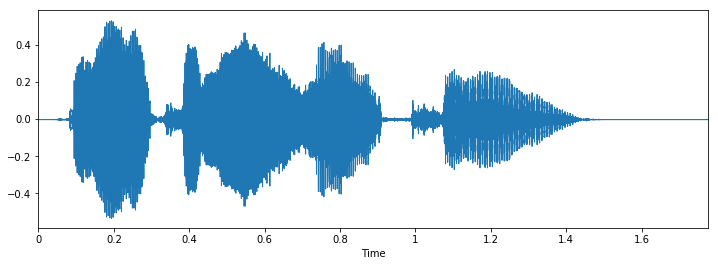

In [2]:
data, sampling_rate = librosa.load('F:/4 year/NLP/project/file/test/eng/bro can I help you.mp3')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

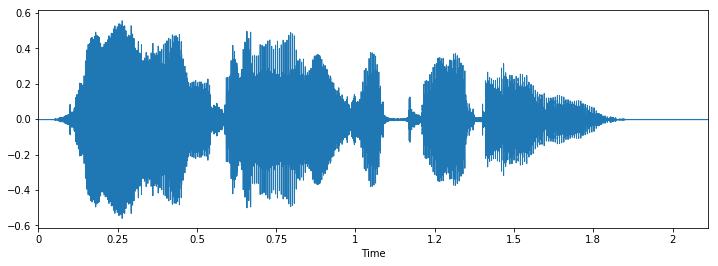

In [4]:
data, sampling_rate = librosa.load('F:/4 year/NLP/project/file/test/eng/bro there is problem.mp3')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)




In [ ]:
def extract_feature(file_name):
    
    X, sample_rate = librosa.load(file_name)
    
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    
    #print(file_name + str(mfccs.shape) + str(chroma.shape) + str(mel.shape) + str(contrast.shape) + str(tonnetz.shape))
    #in total we get 193 features-> Therefore the size of Numpy array is 193
    
    return mfccs,chroma,mel,contrast,tonnetz

# finding all the files in a folder with extension .mp3
# sub_dir will has all the audio files
# parent_dir will have folders for different language audio files 
def parse_audio_files(parent_dir,sub_dirs,file_ext="*.mp3"):
    
    
    features, labels = np.empty((0,193)), np.empty(0)
    
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            
            
            try:
              mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
              print ("Error encountered while parsing file: ", fn)
              continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            
            if sub_dir=='hindi':
                labels = np.append(labels, 0)
            elif sub_dir=='eng':
                labels = np.append(labels, 1)            
                            
    return np.array(features) , np.array(labels, dtype = np.int)




In [ ]:
parent_dir = 'F:/4 year/NLP/project/file/train'
tr_sub_dirs = ["hindi","eng"]

test_parent_dir = 'F:/4 year/NLP/project/file/test'
test_sub_dirs = ["hindi", "eng"]



tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)

tst_features, tst_labels = parse_audio_files(test_parent_dir,test_sub_dirs)


#print(tr_features.shape,tr_labels.shape)
print(tr_labels)


for i,data in enumerate(tr_features):
    print(i)
    print("-------------")
    print(data)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [ ]:
# model from http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/



class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(193, 280)
        self.l2 = nn.Linear(280, 300)
        self.l3 = nn.Linear(300, 1)
        self.tan =nn.Tanh()
        self.sigmoid=nn.Sigmoid()

    def forward(self, x):
        #x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = self.tan(self.l1(x))
        x = self.tan(self.l2(x))
        x = self.sigmoid(self.l3(x))
        return x


model = Net()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

tr_features = Variable ( torch.FloatTensor(tr_features) )
tr_labels1 = Variable ( torch.FloatTensor(tr_labels) )

tst_features = Variable ( torch.FloatTensor(tst_features) )
tst_labels1 = Variable ( torch.FloatTensor(tst_labels) )



def train(epoch):
    
    for i,data in enumerate(tr_features):
        
        targetTnsr=tr_labels1[i]
        targetTnsr=torch.tensor([targetTnsr])
           
    
        #target = torch.from_numpy(target)
        
        data, targetTnsr = Variable(data), Variable(targetTnsr)
    
        optimizer.zero_grad()
        output = model(data)
        print("Output "+str(output))
        print("Target "+str(targetTnsr))
        loss = criterion(output, targetTnsr)
        print(loss)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))

def test():

    test_loss = 0
    correct = 0
    for i,data in enumerate(tst_features):
        targetTnsr=tst_labels1[i]
        targetTnsr=torch.tensor([targetTnsr])
       
        data, targetTnsr = Variable(data), Variable(targetTnsr)
        optimizer.zero_grad()
        output = model(data)
        
        # sum up batch loss
        loss = criterion(output, targetTnsr)
        test_loss += loss
        pred = output.data

        if int(pred.data.numpy()[0])==round(tr_labels[i]):
            correct += 1
        
        
       

        print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))
        
        
        
    

    test_loss /= 11
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, 11,
        100. * correct / 11))
    return (correct / 11)



acc=[]
npacc=np.empty(0)
totalEpoch = 100
for epoch in range(1, totalEpoch):
    train(epoch)
    print('\n')
    ac = test()
    acc.append(ac)
    npacc = np.asarray(acc)
    print("------------------")
print(npacc)
print(len(acc))

In [ ]:
epoc=range(1, totalEpoch)
plt.plot(epoc, acc, 'ro')
plt.axis([0, totalEpoch, 0, 1])
plt.show()